In [30]:
import numpy as np
import pandas as pd
import time
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ttest_ind

The first flight heavier than air took place in 1903, since then, planes have been used for transport on commercial flights. This industry has seen a lot of technological improvements over this more than 100 years lifespan. 
<br><b>Is flying safer now than it ever was ?</b>

Let's start by scraping our data, wikipedia has a page that records every accidents and incidents involving commercial aircrafts. We will get infos about location, date, number of passengers, fatalities, type of aircraft and cause of the incident.

In [2]:
start = "https://en.wikipedia.org"
wiki = "/wiki/List_of_accidents_and_incidents_involving_commercial_aircraft"
page = requests.get(start+wiki).text
soup = BeautifulSoup(page, 'html.parser')

In [3]:
urls = []

for bolds in soup.find_all('b'):
    for links in bolds.find_all('a'):
        urls.append(start + links.get('href'))
        
urls = urls[0:1274]

In [4]:
table = []
headers = ["Date", "Site", "Passengers", "Crew", 
           "Fatalities", "Injuries", "Survivors", "Summary", 'Aircraft\xa0type']
for url in urls:
    dico = {}
    page = requests.get(url).text
    soup = BeautifulSoup(page)
    try:
        for infobox in soup.find('table', {"class": "infobox vcard vevent"}):
            for th in infobox.find_all("th", {"scope": "row"}):
                if th.text in headers:
                    dico[th.text] = th.next_sibling.text
        table.append(dico)       
    except TypeError:
        pass
    time.sleep(1)

In [7]:
df = pd.DataFrame.from_dict(table)
df = df.drop(columns=['Injuries'])

df.Fatalities = df.Fatalities.str.extract('(\d+)')
df.Crew = df.Crew.str.extract('(\d+)')
df.Passengers = df.Passengers.str.extract('(\d+)')
df.Survivors = df.Survivors.str.extract('(\d+)')
df['Year'] = df.Date.str.extract('(\d\d\d\d)')

#Dropping all the rows with missing values
df = df.dropna()
df.Fatalities = df.Fatalities.astype('int')
df.Crew = df.Crew.astype('int')
df.Passengers = df.Passengers.astype('int')
df.Survivors = df.Survivors.astype('int')
df.Year = df.Year.astype('int')

In [8]:
df.head()

,Aircraft type,Crew,Date,Fatalities,Passengers,Site,Summary,Survivors,Year
0,Type FD dirigible,3,"July 21, 1919",13,2,"Chicago, Illinois, United States 41°52′41.25″N...",In-flight fire,2,1919
1,Caproni Ca.48,2,"August 2, 1919 (1919-08-02)",14,12,"Verona, Italy 45°23′47″N 10°53′17″E﻿ / ﻿45.396...",Possible structural failure,0,1919
2,Handley Page O/400,2,"December 14, 1920 (1920-12-14)",4,6,"Golders Green, London 51°34′13.5″N 0°12′11.07″...",CFIT for reasons unknown,4,1920
4,Farman F.60 Goliath,2,14 May 1923 (1923-05-14),6,4,"Monsures, Somme, France 49°42′36″N 2°10′19″E﻿ ...",Structural failure,0,1923
5,Farman F.60 Goliath,2,27 August 1923 (1923-08-27),1,11,"East Malling, Kent, United Kingdom Coordinates...","Engine failure, passenger error, loss of control",12,1923


The result of the scraping, after some cleaning, gives us informations about 1102 incidents. We have now access to the Aircraft type as a string, number of crew members on board as an integer, the Date as a string, number of fatalities as an integer, number of passenegrs as an integer, site of teh incident as a string, a quick summary of the cause of teh incident as a string, number of survivors as an integer and year of the incident as an integer. To start off : 
<br><b>What has the general trend in commercial aviation safety been ?</b>

In [9]:
df.describe()

,Crew,Fatalities,Passengers,Survivors,Year
count,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000
mean,6.692098,46.894641,72.367847,32.221617,1981.756585
std,4.409558,55.434595,73.630651,70.662552,22.432986
min,1.000000,0.000000,0.000000,0.000000,1919.000000
25%,4.000000,7.000000,19.000000,0.000000,1966.000000
50%,6.000000,28.000000,48.000000,0.000000,1982.000000
75%,8.000000,66.000000,103.000000,22.000000,2001.000000
max,61.000000,520.000000,509.000000,521.000000,2018.000000


At first glance we see that the first recorded incident took place in 1919, this makes sense since commercial use of aircrafts developped only after WWI, countries had extra aircrafts left after the war and decided to use them to generate profit.

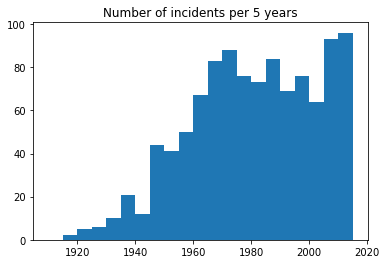

In [10]:
plt.hist(df.Year, bins=np.arange(1910, 2020, 5))
plt.title('Number of incidents per 5 years')
plt.show()

Looking at the number of incidents per year, we see that there were less incidents early on than after 1960. However, this does not account for how many flights are taken each year, a greater number of flights could mean a greater number incidents and without access to the number of flights per year we cannot say it is more dangerous to fly now than it was before.

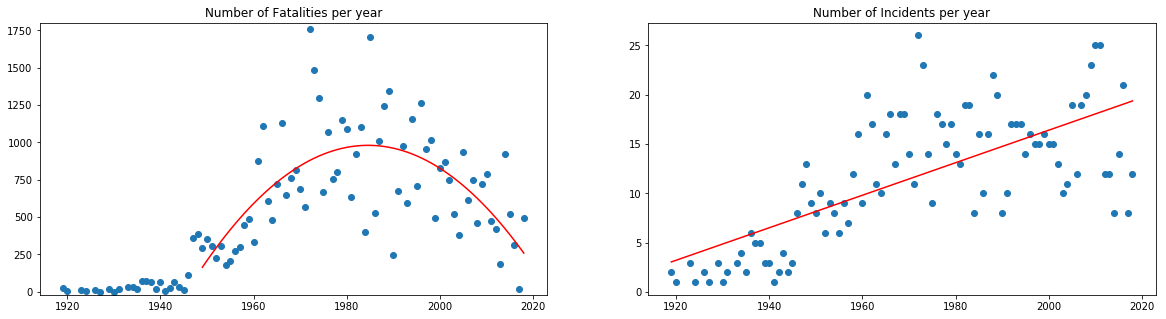

In [11]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.scatter(df.groupby('Year').count().index, df.groupby('Year').sum()['Fatalities'])
plt.title('Number of Fatalities per year')
z = np.polyfit(df.groupby('Year').count().index[-70:], df.groupby('Year').sum()['Fatalities'][-70:], 2)
p = np.poly1d(z)
plt.plot(df.groupby('Year').count().index[-70:], p(df.groupby('Year').count().index[-70:]),"r")
plt.ylim(bottom=-20, top=1800)


plt.subplot(1, 2, 2)
plt.scatter(df.groupby('Year').count().index, df.groupby('Year').count()['Fatalities'])
plt.title('Number of Incidents per year')

z = np.polyfit(df.groupby('Year').count().index, df.groupby('Year').count()['Fatalities'], 1)
p = np.poly1d(z)
plt.plot(df.groupby('Year').count().index,p(df.groupby('Year').count().index),"r")


plt.show()

Instead, let's look at the number of fatalities each year. Once more, having more flights should mean having more fatalities. However, even if we can see that the number of incidents each year is indeed increasing, the number of fatalities sees a peak around 1980 and has been decreasing since. This could mean that even if more incidents happen today, they probably are not as catastrophic as they used to be.

In [12]:
from scipy.stats import ttest_rel
ttest_rel(df.groupby('Year').sum()['Fatalities'],
                     df.groupby('Year').count()['Fatalities'])

Ttest_relResult(statistic=12.051498236891039, pvalue=8.946515066098898e-21)

The shape of the yearly fatalities seems like a quadratic function. However, it seems like a stretch to say that some time in the future the number of fatalities will be very close to zero. To investigate this we will take a look and ask : 
<br><b>Could a single incident cause a high number of fatalities ?</b>

In [22]:
survival_rate = df.Survivors*100/(df.Crew+df.Passengers)
percent_fatalities = df.Fatalities*100/(df.Crew+df.Passengers)
df['Survival rate'] = survival_rate

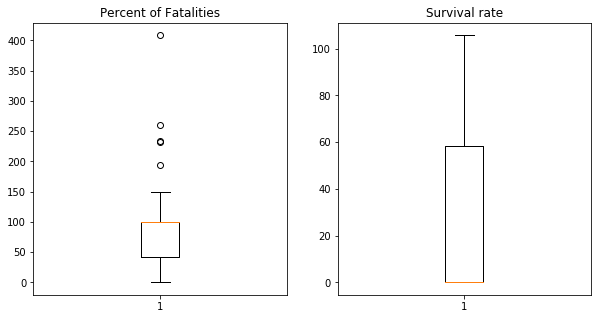

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.boxplot(percent_fatalities)
plt.title('Percent of Fatalities')
plt.subplot(1, 2, 2)
plt.boxplot(df['Survival rate'])
plt.title('Survival rate')
plt.show()

Looking at the rate of fatalities and survival per incident, we see that the median for fatalities is 100% and accordingly the survival rate is 0%. Some values seem odd, with a fatality or survival rate over 100%, let's look at these cases.

In [24]:
df.loc[percent_fatalities.idxmax()]

Aircraft type                         Boeing C-97G Stratofreighter
Crew                                                             4
Date                                                  30 July 1987
Fatalities                                                      49
Passengers                                                       8
Site             Toluca - Mexico City highway, Cuajimalpa, Mexi...
Summary          Crashed onto highway due to cargo shift and ge...
Survivors                                                        7
Year                                                          1987
Survival rate                                              58.3333
Name: 695, dtype: object

In [25]:
df.loc[survival_rate.idxmax()]

Aircraft type                                    Tupolev Tu-154B-2
Crew                                                             8
Date                                                1 January 2011
Fatalities                                                       3
Passengers                                                     116
Site             Surgut International Airport, Surgut, Russia 6...
Summary                                            Electrical fire
Survivors                                                      131
Year                                                          2011
Survival rate                                              105.645
Name: 1132, dtype: object

In the case of fatalities, we can see that more people died than the number of people on board. In this case the plane crashed into a busy highway causing more fatalities. This is the case for several incidents. Therefore, we will focus on the survival rate which takes only the people on board into account. The odd case out results from off duty crew members not counted as either crew or passengers.

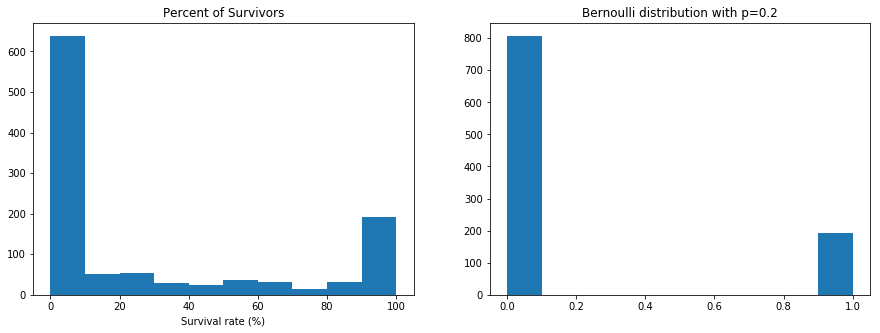

In [26]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.hist(survival_rate, bins=np.arange(0, 110, 10))
plt.title('Percent of Survivors')
plt.xlabel('Survival rate (%)')

plt.subplot(1, 2, 2)
bernoulli= np.random.binomial(1, 0.2, 1000)
plt.hist(bernoulli, bins=np.arange(0, 1.1, 0.1))
plt.title('Bernoulli distribution with p=0.2')
plt.show()

Looking more closely at the survival rate, we can see that the repartition seems like a discrete event. Either everyone dies, or everyone survives.

In [31]:
print(ttest_ind(survival_rate, bernoulli, equal_var=False))

Ttest_indResult(statistic=24.00198961931564, pvalue=1.0227064728470803e-102)


Comparing this with a bernoulli repartition we can see that the p value is very close to 0 and that indeed the survival rate can be considered as a discrete event with only usually two possible outcomes : 100% or 0% survival rate.
So even if the number of incidents goes down dramatically in the future, any single incident has a good chance to have a survival rate of 0% and cause a lot of fatalities.

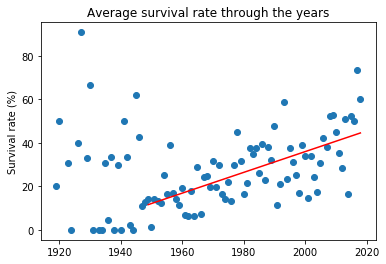

In [32]:
plt.scatter(df.groupby('Year').count().index,
            df.groupby('Year').mean()['Survival rate'])
plt.title('Average survival rate through the years')
plt.ylabel('Survival rate (%)')

z = np.polyfit(df.groupby('Year').count().index[-70:], 
               df.groupby('Year').mean()['Survival rate'][-70:],
               1)
p = np.poly1d(z)
plt.plot(df.groupby('Year').count().index[-70:],
         p(df.groupby('Year').count().index[-70:]),
         "r")
plt.show()

While this might be true looking at all incidents, looking at the average survival rate over the years shows that there is an increasing tendency in survival rate. Even if the result of an incident is discrete, on average, more and more incidents end up with a 100% survival rate indicating progress.
<br>Finally, let's take a look at the causes of incidents to get an idea of where progress has been made and where there is still room for improvement.

In [33]:
causes = {"unknown":"Unknown",
      "investigation":"Unknown",
      "undetermined":"Unknown",
      "disappear":"Unknown",
      "runway":"Ground",
      "landing":"Landing",
      "approach":"Landing",
      "take-off":"Take-off",
      "takeoff":"Take-off",
      "failure":"Failure",
      "engine":"Failure",
       "malfunction":"Failure",
      "weather":"Weather",
      "ice":"Weather",
      "icing":"Weather",
      "light":"Weather",
      "fire":"Fire",
      "explosion":"Fire",
      "hijack":"Terror",
      "bomb":"Terror",
      "suicide":"Terror",
      "terrain":"CFIT",
      "CFIT":"CFIT",
      "crew":"Pilot",
      "pilot":"Pilot"}

In [35]:
for cause in causes:
    df.loc[df['Summary'].str.contains(cause, case=False), "Cause"] = causes[cause]
df.loc[df.Cause.isnull(), "Cause"] = "Other"

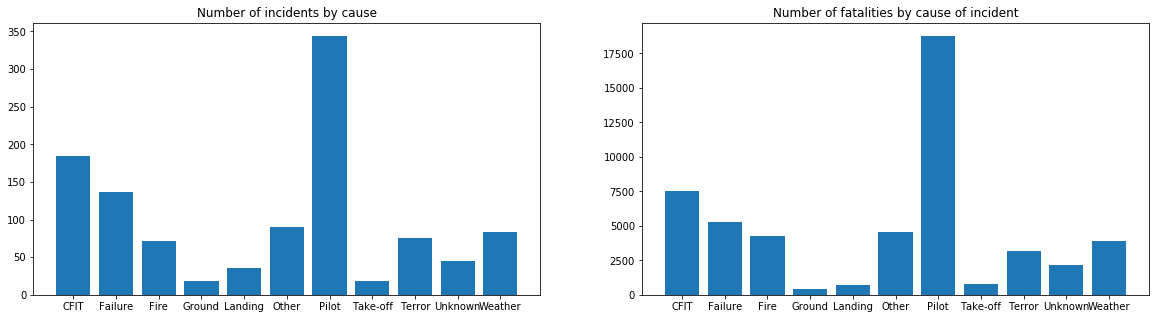

In [36]:
plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.bar(df.groupby('Cause').count()['Fatalities'].index,
        df.groupby('Cause').count()['Fatalities'])
plt.title('Number of incidents by cause')

plt.subplot(1, 2, 2)
plt.bar(df.groupby('Cause').sum()['Fatalities'].index,
        df.groupby('Cause').sum()['Fatalities'])
plt.title('Number of fatalities by cause of incident');

We can immediately see that pilot errors account for nearly double the next most common cause of incidents (CFIT = Controlled Flight Into Terrain). Most notably, any type of mechanical/electrical/technical failure from the plane itself is way less common than pilot errors.

In [37]:
df.groupby('Cause').mean()

,Crew,Fatalities,Passengers,Survivors,Year,Survival rate
Cause,,,,,,
CFIT,5.372973,40.837838,43.264865,7.848649,1974.362162,13.704704
Failure,6.338235,38.970588,73.397059,41.139706,1981.352941,31.599322
Fire,8.597222,59.138889,88.000000,37.805556,1979.680556,33.398526
Ground,7.444444,22.166667,95.666667,81.333333,1994.944444,68.540920
Landing,7.200000,20.714286,78.657143,65.200000,1990.685714,56.579528
Other,6.333333,50.411111,70.366667,26.344444,1978.944444,23.027293
Pilot,6.720930,54.555233,77.950581,30.261628,1985.002907,27.324526
Take-off,6.555556,45.333333,76.777778,38.000000,1989.111111,33.464626
Terror,9.053333,42.120000,107.480000,74.053333,1984.733333,52.714142


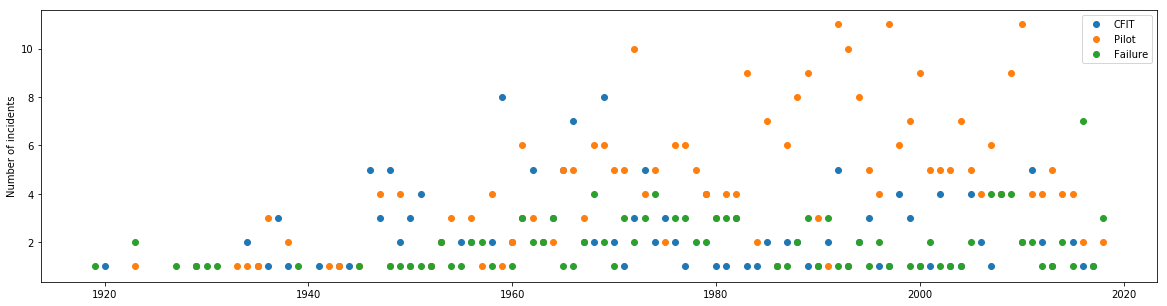

In [38]:
plt.figure(figsize=(20,5))
plt.scatter(df[df['Cause'].str.match('CFIT')].groupby('Year').count()['Cause'].index,
            df[df['Cause'].str.match('CFIT')].groupby('Year').count()['Cause'])

plt.scatter(df[df['Cause'].str.match('Pilot')].groupby('Year').count()['Cause'].index,
            df[df['Cause'].str.match('Pilot')].groupby('Year').count()['Cause'])

plt.scatter(df[df['Cause'].str.match('Failure')].groupby('Year').count()['Cause'].index,
            df[df['Cause'].str.match('Failure')].groupby('Year').count()['Cause'])

plt.ylabel("Number of incidents")
plt.legend(["CFIT", "Pilot", "Failure"]);

Looking at the survival rate though, CFIT's are the most dangerous cause of incidents with a 13.78% survival rate on average. When looking at the average year the incidents occured, we see that pilot errors match the average of all incidents (1984), whereas technical difficulties seem to be an older issue (1981 on average) and where never the leading cause of incident. CFIT do not seem to happen that often more recently anymore.

All in all, we have seen great improvement in the survival rate, even if the number of incidents is going up in par with the number of flights. Pilot error remains the biggest safety issue and should be an area of emphasis for airlines trying to provide the safest travel possible considering a single incident is usually enough to make big headlines.

Future research could provide more insight on actual correlation (through regression). We could also use additional economical data by country and also the number of daily flights. It could be interesting to look at what parts of the world and/or companies are more dangerous, which would lead to the question : 
<br><b>Has progress in aviation safety been asymetrical depending on amount of money put into it ?</b>